In [49]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [50]:
# generated by ChatGPT
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


In [51]:
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.transform = transform
        # Search recursively for jpg images
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)
        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (32, 32), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations: resize to 32x32, convert to tensor, normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Set your dataset root and create DataLoader.
dataset_root = "./archive/"
weather_dataset = WeatherDataset(root_dir=dataset_root, transform=transform)
batch_size = 256
dataloader = DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Found 819 images.


In [55]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2048):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder for 256x256 input:
        # 256x256 -> 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        self.encoder = nn.Sequential(
            # Layer 1: 256 -> 128
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # Output: 32x128x128
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2: 128 -> 64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),    # Output: 64x64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3: 64 -> 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4: 32 -> 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5: 16 -> 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 512x8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 6: 8 -> 4
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1), # Output: 1024x4x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # The flattened feature map size is now 1024 * 4 * 4 = 16384.
        self.flatten_dim = 1024 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder: Upsample from 4x4 back to 256x256
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            # Upsample from 4x4 to 8x8
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # Output: 512x8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 8x8 to 16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),   # Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 32x32 to 64x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # Output: 64x64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 64x64 to 128x128
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # Output: 32x128x128
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 128x128 to 256x256
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),      # Output: 3x256x256
            nn.Tanh()  # Outputs are normalized to [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        # Encode
        enc_out = self.encoder(x)
        enc_out = enc_out.view(batch_size, -1)
        mu = self.fc_mu(enc_out)
        logvar = self.fc_logvar(enc_out)
        z = self.reparameterize(mu, logvar)
        # Decode
        dec_input = self.decoder_input(z)
        dec_input = dec_input.view(batch_size, 1024, 4, 4)
        reconstruction = self.decoder(dec_input)
        return reconstruction, mu, logvar

In [56]:
def loss_function(recon_x, x, mu, logvar):
    # Mean Squared Error loss for reconstruction
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

vae = VAE(latent_dim=2048).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [57]:
num_epochs = 20000  # Adjust as needed
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(weather_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

KeyboardInterrupt: 

In [46]:
# After training, save the VAE's state dictionary
torch.save(vae.state_dict(), "vaepocketdos.pth")
print("VAE model saved!")

VAE model saved!


VAE model loaded!


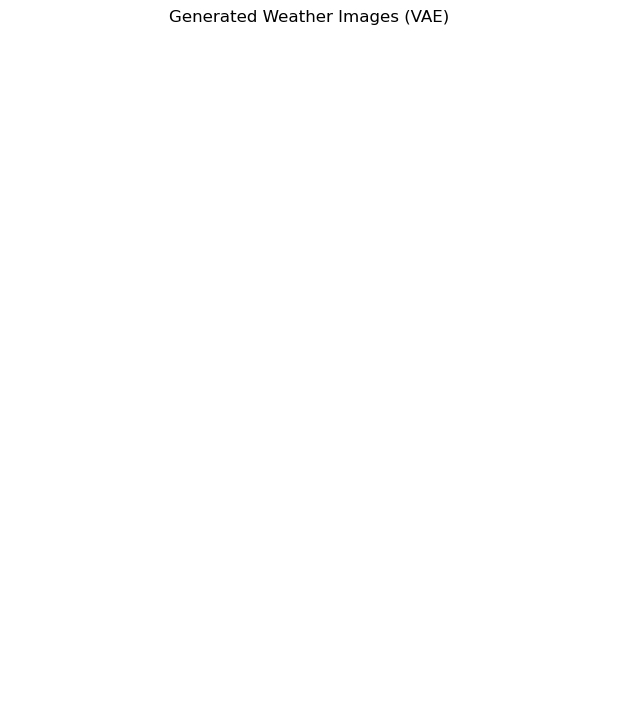

In [47]:
# Initialize the VAE and load the saved weights
vae = VAE(latent_dim=2048).to(device)
# Use weights_only=True for safer loading (if supported)
vae.load_state_dict(torch.load("vaepocketdos.pth", map_location=device, weights_only=True))
vae.eval()  # Set the model to evaluation mode

print("VAE model loaded!")

# Generate images from the VAE for 256x256 output

n_samples = 16
# Sample latent vectors of dimension 2048 (matching our VAE's latent space)
sampled_z = torch.randn(n_samples, 2048).to(device)
with torch.no_grad():
    # Pass the latent vectors through the decoder input layer
    dec_input = vae.decoder_input(sampled_z)
    # Reshape to (n_samples, 1024, 4, 4) as expected by the decoder
    dec_input = dec_input.view(n_samples, 1024, 4, 4)
    # Generate images using the decoder
    generated = vae.decoder(dec_input).cpu()

# Denormalize images from [-1, 1] to [0, 1]
generated = (generated + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    # Transpose to (height, width, channels) for imshow
    ax.imshow(np.transpose(generated[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (VAE)")
plt.show()


In [58]:

class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent vector Z of shape (nz, 1, 1)
            nn.ConvTranspose2d(nz, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: 1024 x 4 x 4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 32 x 128 x 128
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 3 x 256 x 256
            nn.Tanh()  # Outputs normalized to [-1, 1]
        )

    def forward(self, input):
        return self.main(input)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 32 x 128 x 128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 1024 x 4 x 4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)



In [59]:
nz = 256  # dimension of noise vector
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

num_epochs_gan = 20000  # Increase for better results!
real_label = 1.
fake_label = 0.


In [60]:
print("Starting GAN Training...")
for epoch in range(num_epochs_gan):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Train with real images
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to label as real
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs_gan}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}")


Starting GAN Training...
[1/20000] Loss_D: 6.3500 Loss_G: 9.4440
[2/20000] Loss_D: 1.0974 Loss_G: 13.5564
[3/20000] Loss_D: 0.3744 Loss_G: 10.5436
[4/20000] Loss_D: 1.2117 Loss_G: 19.1003
[5/20000] Loss_D: 0.0165 Loss_G: 5.1039
[6/20000] Loss_D: 0.1203 Loss_G: 14.8711
[7/20000] Loss_D: 2.7829 Loss_G: 19.1079
[8/20000] Loss_D: 0.0044 Loss_G: 17.0020
[9/20000] Loss_D: 0.0111 Loss_G: 5.2355
[10/20000] Loss_D: 0.0372 Loss_G: 9.8136
[11/20000] Loss_D: 0.1876 Loss_G: 15.6212
[12/20000] Loss_D: 0.0094 Loss_G: 7.1881
[13/20000] Loss_D: 0.0066 Loss_G: 16.5730
[14/20000] Loss_D: 0.0044 Loss_G: 12.2596
[15/20000] Loss_D: 0.6303 Loss_G: 14.7462
[16/20000] Loss_D: 0.0817 Loss_G: 3.8874
[17/20000] Loss_D: 0.0308 Loss_G: 11.6324
[18/20000] Loss_D: 6.0888 Loss_G: 13.2516
[19/20000] Loss_D: 0.0167 Loss_G: 8.5023
[20/20000] Loss_D: 0.7083 Loss_G: 12.3426
[21/20000] Loss_D: 0.0674 Loss_G: 3.7884
[22/20000] Loss_D: 0.0342 Loss_G: 9.3014
[23/20000] Loss_D: 0.0413 Loss_G: 6.9620
[24/20000] Loss_D: 0.0248 Lo

KeyboardInterrupt: 

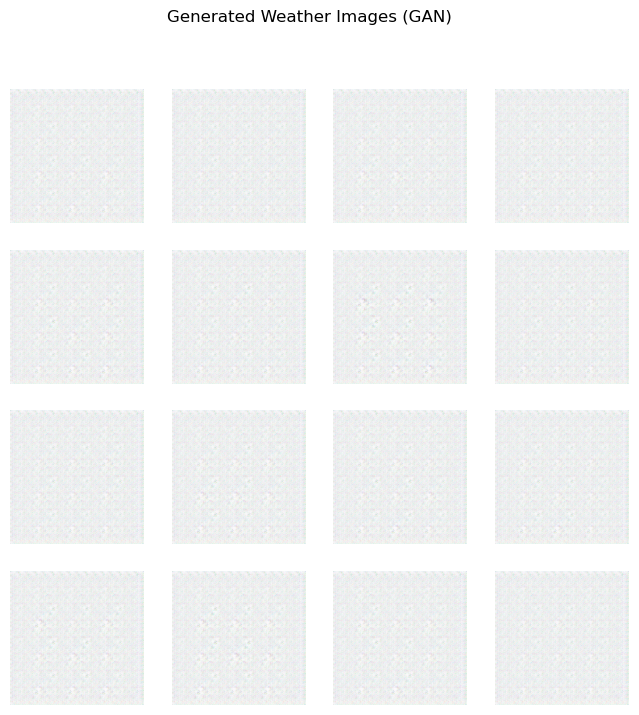

In [68]:
# Generate images from the GAN
netG.eval()
n_samples = 16
noise = torch.randn(n_samples, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(noise).cpu()

# Denormalize from [-1,1] to [0,1]
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1,2,0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (GAN)")
plt.show()


In [69]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 256  # dimension of noise vector (must match training)

# Create generator instance and load the saved weights
netG = Generator(nz=nz).to(device)
netG.load_state_dict(torch.load("netGpocketdos.pth", map_location=device, weights_only=True))

netG.eval()  # set to evaluation mode

print("Generator loaded!")


Generator loaded!


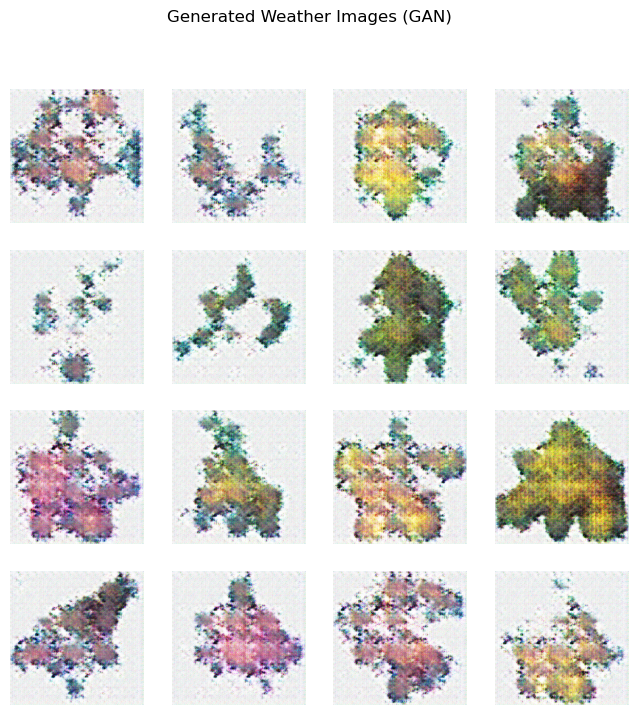

In [70]:
import matplotlib.pyplot as plt
import numpy as np

n_samples = 16
noise = torch.randn(n_samples, nz, 1, 1, device=device)  # create latent noise vectors

with torch.no_grad():
    fake_images = netG(noise).cpu()  # generate images

# Denormalize from [-1,1] to [0,1]
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (GAN)")
plt.show()


In [62]:
# Save the generator and discriminator state dictionaries
torch.save(netG.state_dict(), "netGpocketdos.p"
                              "th")
torch.save(netD.state_dict(), "netDpocketdos.pth")
print("Models saved!")

Models saved!
